# A1_4 – Regularisation

In this notebook we compare different regularisation techniques applied to our neturalnet_torch model.

More specifically, we compare:

- L1/L2 Regularisation
- Dropout Regularisation

For each:

- We experiment with different parameters
- We present the results of the evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import joblib

base = os.path.dirname(os.getcwd())  
sys.path.append(os.path.join(base, "models"))
sys.path.append(os.path.join(base, "utils"))

from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils import predict_batch, mape, evaluate_regression
from NeuralNet import NeuralNet                      # manual BP implementation
from mlr_sklearn import MultipleLinearRegressionSK   # simple MLR wrapper
from neuralnet_torch import NeuralNetTorch           # PyTorch implementation

In [2]:
# Load preprocessed data from ./data
X_trainval_np = np.load("../data/X_trainval_np.npy")
X_test_np     = np.load("../data/X_test_np.npy")

y_trainval = np.load("../data/y_trainval.npy")
y_test     = np.load("../data/y_test.npy")

y_trainval_scaled = np.load("../data/y_trainval_scaled.npy")
y_test_scaled     = np.load("../data/y_test_scaled.npy")

x_scaler = joblib.load("../data/x_scaler.joblib")
y_scaler = joblib.load("../data/y_scaler.joblib")

n_features = X_trainval_np.shape[1]
print("Loaded preprocessed data from ../data")
print("X_trainval_np:", X_trainval_np.shape)
print("X_test_np    :", X_test_np.shape)
print("n_features   :", n_features)

Loaded preprocessed data from ../data
X_trainval_np: (1200, 61)
X_test_np    : (300, 61)
n_features   : 61


In [3]:
# Selected configuration for manual BP, we copy here the desired Hyperpaarameters from the notebook 2

hidden_layers_bp = [40, 15]
epochs_bp = 600
lr_bp = 0.005
momentum_bp = 0.9
activation_bp = "tanh"

print("Manual BP selected configuration:")
print("Hidden layers :", hidden_layers_bp)
print("Epochs        :", epochs_bp)
print("Learning rate :", lr_bp)
print("Momentum      :", momentum_bp)
print("Activation    :", activation_bp)


Manual BP selected configuration:
Hidden layers : [40, 15]
Epochs        : 600
Learning rate : 0.005
Momentum      : 0.9
Activation    : tanh


In [4]:

# 1) Manual Backprop Neural Network (selected config)


layers_bp = [n_features] + hidden_layers_bp + [1]

net_manual = NeuralNet(
    n=layers_bp,
    fact=activation_bp,
    eta=lr_bp,
    alpha=momentum_bp,
    epochs=epochs_bp,
    val_split=0.2
)

# Train on the 80% (network internally splits into train/val)
net_manual.fit(X_trainval_np, y_trainval_scaled)

# Error evolution per epoch (from NeuralNet)
train_err_manual, val_err_manual = net_manual.loss_epochs()

# --- Predictions in scaled space ---
y_trainval_pred_manual_scaled = predict_batch(net_manual, X_trainval_np)
y_test_pred_manual_scaled     = predict_batch(net_manual, X_test_np)

# --- Back to original target scale (cnt_log) ---
y_trainval_pred_manual = y_scaler.inverse_transform(y_trainval_pred_manual_scaled).ravel()
y_test_pred_manual     = y_scaler.inverse_transform(y_test_pred_manual_scaled).ravel()

# --- Metrics (in original cnt_log scale) ---
metrics_manual_trainval = evaluate_regression(y_trainval, y_trainval_pred_manual)
metrics_manual_test     = evaluate_regression(y_test,     y_test_pred_manual)

print("=== Manual BP Neural Network (selected config) ===")
print("TRAIN+VAL:", metrics_manual_trainval)
print("TEST     :", metrics_manual_test)


Neural network has been initialized
Architecture (neurons per layer): [61, 40, 15, 1]
Activation function used: tanh
 Layer 1: w(40, 61), theta(40, 1)
 Layer 2: w(15, 40), theta(15, 1)
 Layer 3: w(1, 15), theta(1, 1)
Epoch 0: Train MSE=0.127058 | Val MSE=0.048205
Epoch 100: Train MSE=0.000443 | Val MSE=0.020370
Epoch 200: Train MSE=0.000188 | Val MSE=0.018025
Epoch 300: Train MSE=0.000095 | Val MSE=0.017237
Epoch 400: Train MSE=0.000068 | Val MSE=0.017525
Epoch 500: Train MSE=0.000077 | Val MSE=0.017006
=== Manual BP Neural Network (selected config) ===
TRAIN+VAL: {'MSE': 0.014288310432863846, 'MAE': 0.044888349085324505, 'MAPE': 1.5567978953578774}
TEST     : {'MSE': 0.0869461751371478, 'MAE': 0.15365092853358397, 'MAPE': 7.30295097168306}


In [6]:

# 2) Multiple Linear Regression (scikit-learn)


mlr = MultipleLinearRegressionSK(fit_intercept=True)

# Train on scaled features and scaled target (same as neural networks)
mlr.fit(X_trainval_np, y_trainval_scaled)

# Predictions in scaled space
y_trainval_pred_mlr_scaled = mlr.predict(X_trainval_np).reshape(-1, 1)
y_test_pred_mlr_scaled     = mlr.predict(X_test_np).reshape(-1, 1)

# Back to original target scale (cnt_log)
y_trainval_pred_mlr = y_scaler.inverse_transform(y_trainval_pred_mlr_scaled).ravel()
y_test_pred_mlr     = y_scaler.inverse_transform(y_test_pred_mlr_scaled).ravel()

# Metrics (in original cnt_log scale)
metrics_mlr_trainval = evaluate_regression(y_trainval, y_trainval_pred_mlr)
metrics_mlr_test     = evaluate_regression(y_test,     y_test_pred_mlr)

print("=== Multiple Linear Regression (scikit-learn) ===")
print("TRAIN+VAL:", metrics_mlr_trainval)
print("TEST     :", metrics_mlr_test)


Multiple Linear Regression (scikit-learn) initialized.
fit_intercept: True
=== Multiple Linear Regression (scikit-learn) ===
TRAIN+VAL: {'MSE': 0.20247073221894377, 'MAE': 0.316183852848378, 'MAPE': 10.622396013879072}
TEST     : {'MSE': 0.22018721386256768, 'MAE': 0.3201973636727168, 'MAPE': 12.332372304806864}


In [7]:

# 3) PyTorch Neural Network (same config as manual BP)


hidden_layers_torch = hidden_layers_bp
layers_torch = [n_features] + hidden_layers_torch + [1]

net_torch = NeuralNetTorch(
    n=layers_torch,
    fact=activation_bp,   # same activation
    eta=lr_bp,            # same learning rate
    alpha=momentum_bp,    # same momentum
    epochs=epochs_bp,     # same number of epochs
    val_split=0.2         # same validation split
)

# Train with scaled data
net_torch.fit(X_trainval_np, y_trainval_scaled, 'L1')

# Loss history for later plots
train_err_torch, val_err_torch = net_torch.loss_epochs()

# Predictions in scaled space
y_trainval_pred_torch_scaled = net_torch.predict(X_trainval_np).reshape(-1, 1)
y_test_pred_torch_scaled     = net_torch.predict(X_test_np).reshape(-1, 1)

# Back to original target scale (cnt_log)
y_trainval_pred_torch = y_scaler.inverse_transform(y_trainval_pred_torch_scaled).ravel()
y_test_pred_torch     = y_scaler.inverse_transform(y_test_pred_torch_scaled).ravel()

# Metrics (in original cnt_log scale)
metrics_torch_trainval = evaluate_regression(y_trainval, y_trainval_pred_torch)
metrics_torch_test     = evaluate_regression(y_test,     y_test_pred_torch)

print("=== PyTorch Neural Network (same config) ===")
print("TRAIN+VAL:", metrics_torch_trainval)
print("TEST     :", metrics_torch_test)


NeuralNetTorch (PyTorch) initialized
 - Layers: [61, 40, 15, 1]
 - Activation: tanh
 - Learning rate: 0.005 | Momentum: 0.9
 - Epochs: 600 | Val split: 0.2
Epoch 0: Train MSE=1.052289 | Val MSE=1.044997
Epoch 100: Train MSE=0.093664 | Val MSE=0.100875
Epoch 200: Train MSE=0.078249 | Val MSE=0.086061
Epoch 300: Train MSE=0.067877 | Val MSE=0.077842
Epoch 400: Train MSE=0.058703 | Val MSE=0.070829
Epoch 500: Train MSE=0.050387 | Val MSE=0.064515
=== PyTorch Neural Network (same config) ===
TRAIN+VAL: {'MSE': 0.08771504904564707, 'MAE': 0.1888117539474076, 'MAPE': 7.2628399272350235}
TEST     : {'MSE': 0.1330885235125012, 'MAE': 0.21278906120153365, 'MAPE': 9.565416387224499}


In [8]:

# Comparison tables: TRAIN+VAL and TEST metrics


results_trainval = {
    "Model": ["Manual BP", "MLR (SK)", "PyTorch NN"],
    "MSE":   [
        metrics_manual_trainval["MSE"],
        metrics_mlr_trainval["MSE"],
        metrics_torch_trainval["MSE"],
    ],
    "MAE":   [
        metrics_manual_trainval["MAE"],
        metrics_mlr_trainval["MAE"],
        metrics_torch_trainval["MAE"],
    ],
    "MAPE":  [
        metrics_manual_trainval["MAPE"],
        metrics_mlr_trainval["MAPE"],
        metrics_torch_trainval["MAPE"],
    ],
}

results_test = {
    "Model": ["Manual BP", "MLR (SK)", "PyTorch NN"],
    "MSE":   [
        metrics_manual_test["MSE"],
        metrics_mlr_test["MSE"],
        metrics_torch_test["MSE"],
    ],
    "MAE":   [
        metrics_manual_test["MAE"],
        metrics_mlr_test["MAE"],
        metrics_torch_test["MAE"],
    ],
    "MAPE":  [
        metrics_manual_test["MAPE"],
        metrics_mlr_test["MAPE"],
        metrics_torch_test["MAPE"],
    ],
}

df_trainval = pd.DataFrame(results_trainval)
df_test     = pd.DataFrame(results_test)

print("=== TRAIN+VAL metrics (80%) ===")
display(df_trainval)

print("=== TEST metrics (20%) ===")
display(df_test)


=== TRAIN+VAL metrics (80%) ===


,Model,MSE,MAE,MAPE
0,Manual BP,0.014288,0.044888,1.556798
1,MLR (SK),0.202471,0.316184,10.622396
2,PyTorch NN,0.087715,0.188812,7.262840


=== TEST metrics (20%) ===


,Model,MSE,MAE,MAPE
0,Manual BP,0.086946,0.153651,7.302951
1,MLR (SK),0.220187,0.320197,12.332372
2,PyTorch NN,0.133089,0.212789,9.565416


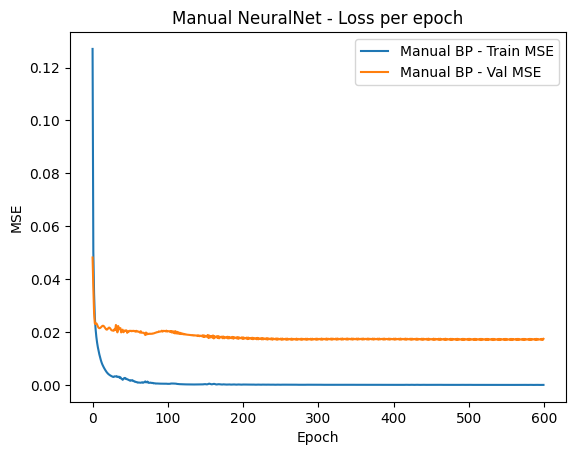

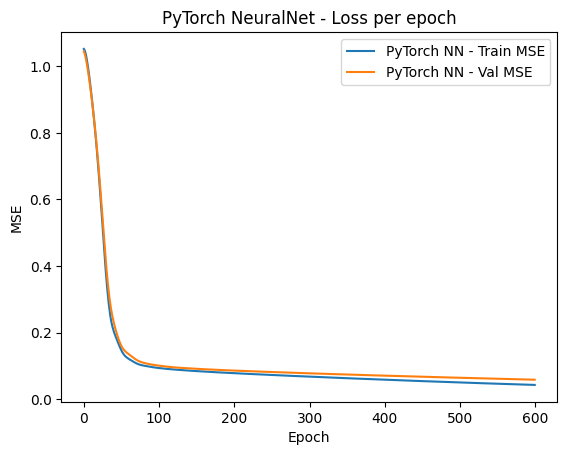

In [9]:

# Loss curves for manual BP and PyTorch

plt.figure()
plt.plot(train_err_manual, label="Manual BP - Train MSE")
if any(e is not None for e in val_err_manual):
    plt.plot([e for e in val_err_manual if e is not None], label="Manual BP - Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Manual NeuralNet - Loss per epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_err_torch, label="PyTorch NN - Train MSE")
if any(e is not None for e in val_err_torch):
    plt.plot([e for e in val_err_torch if e is not None], label="PyTorch NN - Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("PyTorch NeuralNet - Loss per epoch")
plt.legend()
plt.show()


In [ ]:

# Scatter plots: true vs predicted on TEST set


plt.figure(figsize=(15, 4))

# Manual BP
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred_manual, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted")
plt.title("Manual BP")

# MLR
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred_mlr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted")
plt.title("MLR (scikit-learn)")

# PyTorch NN
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred_torch, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted")
plt.title("PyTorch NN")

plt.tight_layout()
plt.show()


## Summary of model comparison

In this notebook we compared three regression models on the same
Bike Sharing hourly dataset:

- **Manual BP Neural Network** (custom implementation),
- **Multiple Linear Regression (MLR)** using scikit-learn,
- **PyTorch Neural Network** using the same architecture and hyperparameters as the manual BP model.

The main points are:

- All models were trained on the same **scaled** features and target.
- The manual BP and the PyTorch models used the same:
  - number of layers and neurons,
  - activation function,
  - learning rate, momentum,
  - number of epochs,
  - internal validation split.
- We measured performance using **MSE, MAE and MAPE** on:
  - the 80% train+validation set,
  - the 20% test set.

From the comparison tables and plots we can discuss:

- How the linear model (MLR) behaves compared to the nonlinear neural networks.
- Whether PyTorch reproduces or improves the performance of the manual BP implementation.
- How stable each model is during training (by looking at the loss curves).
- How close the predictions are to the true values on the test set (scatter plots).

